In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import itertools
from scipy import stats
import os
import requests
import gzip
import shutil
import datetime  


np.random.seed(42)

plt.rcParams['font.family'] = 'SimHei'


os.makedirs("data/group_gene/pathway_label", exist_ok=True)

In [48]:
# 1. 生成模拟数据
def generate_simulated_data(n_normal=50, n_disease=50, n_genes=100, n_diff_pairs=20):
    """
    生成模拟数据，包括正常样本和疾病样本的基因表达谱
    
    参数:
    - n_normal: 正常样本数量
    - n_disease: 疾病样本数量
    - n_genes: 基因数量
    - n_diff_pairs: 差异表达的基因对数量
    
    返回:
    - gene_expression: 基因表达矩阵
    - labels: 样本标签 (0=正常, 1=疾病)
    - diff_pairs: 用于生成数据的差异表达基因对列表
    """
    # 生成正常样本的基因表达谱
    normal_expr = np.random.normal(loc=6, scale=1, size=(n_normal, n_genes))
    
    # 生成疾病样本的基因表达谱
    disease_expr = np.random.normal(loc=6, scale=1, size=(n_disease, n_genes))
    
    # 随机选择差异表达的基因对
    diff_pairs = []
    for _ in range(n_diff_pairs):
        i = np.random.randint(0, n_genes)
        j = np.random.randint(0, n_genes)
        while i == j or (i, j) in diff_pairs or (j, i) in diff_pairs:
            i = np.random.randint(0, n_genes)
            j = np.random.randint(0, n_genes)
        diff_pairs.append((i, j))
    
    # 在正常和疾病样本中创建差异表达模式
    for i, j in diff_pairs:
        # 在正常样本中，使基因i的表达高于基因j
        normal_expr[:, i] = normal_expr[:, i] + 1.5
        normal_expr[:, j] = normal_expr[:, j] - 0.5
        
        # 在疾病样本中，使基因j的表达高于基因i
        disease_expr[:, i] = disease_expr[:, i] - 0.5
        disease_expr[:, j] = disease_expr[:, j] + 1.5
    
    # 合并数据和标签
    gene_expression = np.vstack([normal_expr, disease_expr])
    labels = np.array([0] * n_normal + [1] * n_disease)
    
    # 创建基因名称
    gene_names = [f"Gene_{i}" for i in range(n_genes)]
    
    # 创建DataFrame
    df = pd.DataFrame(gene_expression, columns=[('mRNA', gene) for gene in gene_names])
    
    return df, labels, diff_pairs

# 生成模拟通路数据
def generate_pathway_data(n_genes=100, n_pathways=10, pathway_size=20):
    """
    生成模拟的通路数据
    
    参数:
    - n_genes: 基因总数
    - n_pathways: 通路数量
    - pathway_size: 每个通路包含的基因数量
    """
    gene_names = [f"Gene_{i}" for i in range(n_genes)]
    
    with open("data/group_gene/pathway_label/c2.cp.kegg.v7.2.symbols.gmt", "w") as f:
        for p in range(n_pathways):
            # 随机选择通路中的基因
            pathway_genes = np.random.choice(gene_names, size=pathway_size, replace=False)
            pathway_name = f"PATHWAY_{p}"
            pathway_desc = f"Description_of_pathway_{p}"
            
            # 写入通路数据 (格式: 通路名称 通路描述 基因1 基因2 ...)
            f.write(f"{pathway_name}\t{pathway_desc}\t" + "\t".join(pathway_genes) + "\n")
    
    print(f"已生成{n_pathways}个模拟通路，保存在 data/group_gene/pathway_label/c2.cp.kegg.v7.2.symbols.gmt")

In [49]:
# 2. 计算组合数函数
def comb_mine(N, k):
    """计算组合数 C(N,k)"""
    up = np.math.factorial(N)
    down = (np.math.factorial(k) * np.math.factorial(N - k))
    vals = up // down
    return vals

In [50]:
# 3. Fisher精确检验函数
def fisher_exact_test(gene_GSE_T, label, threshold=1e-3):
    """
    使用Fisher精确检验来识别在两组间相对表达显著不同的基因对
    
    参数:
    - gene_GSE_T: 基因表达数据框
    - label: 样本标签
    - threshold: p值阈值
    
    返回:
    - pair_index_exact: 显著基因对的索引
    - pair_index_exact_expressed: 显著基因对的名称
    - max_num: 总基因对数量
    """
    data = gene_GSE_T.values
    columns = gene_GSE_T.columns
    len_gene = len(gene_GSE_T.columns)
    pair_index_exact_expressed = []
    pair_index_exact = []
    max_num = len_gene * (len_gene - 1) / 2
    
    for i in range(0, len_gene - 1):
        for j in range(i + 1, len_gene):
            # 计算每个样本中基因i和基因j的相对表达关系
            pair_each = data[:, i] > data[:, j]
            
            # 构建2x2列联表
            a = np.sum((pair_each > 0.5) * (label < 0.5))  # 正常组中RNA_i > RNA_j的样本数
            c = np.sum((pair_each > 0.5) * (label > 0.5))  # 疾病组中RNA_i > RNA_j的样本数
            b = np.sum((pair_each < 0.5) * (label < 0.5))  # 正常组中RNA_i < RNA_j的样本数
            d = np.sum((pair_each < 0.5) * (label > 0.5))  # 疾病组中RNA_i < RNA_j的样本数
            n = a + b + c + d
            
            # 计算Fisher精确检验的p值
            # p = comb_mine(a + b, a) * comb_mine(c + d, c) / comb_mine(n, a + c)
            
            # 使用scipy提供的Fisher精确检验
            _, p = stats.fisher_exact([[a, b], [c, d]])
            
            # 筛选显著的基因对
            if p < threshold:
                pair_index_exact.append((i, j))
                pair_index_exact_expressed.append((columns[i], columns[j]))
    
    return pair_index_exact, pair_index_exact_expressed, max_num

In [51]:
def download_msigdb_kegg():
    """
    下载MSigDB的KEGG通路数据集
    """
    # 创建必要的目录
    os.makedirs("data/group_gene/pathway_label", exist_ok=True)
    
    # 下载URL - MSigDB的KEGG通路数据集
    url = "https://data.broadinstitute.org/gsea-msigdb/msigdb/release/7.5.1/c2.cp.kegg.v7.5.1.symbols.gmt.gz"
    
    # 下载压缩文件
    print("正在下载MSigDB KEGG通路数据...")
    response = requests.get(url)
    
    # 保存压缩文件
    gz_file_path = "data/group_gene/pathway_label/c2.cp.kegg.symbols.gmt.gz"
    with open(gz_file_path, 'wb') as f:
        f.write(response.content)
    
    # 解压文件
    gmt_file_path = "data/group_gene/pathway_label/c2.cp.kegg.v7.2.symbols.gmt"
    with gzip.open(gz_file_path, 'rb') as f_in:
        with open(gmt_file_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    
    # 删除压缩文件
    os.remove(gz_file_path)
    
    print(f"KEGG通路数据已下载并解压到 {gmt_file_path}")
    
    return gmt_file_path

In [52]:
# 4. 加载通路数据函数
'''
#模拟生成
def load_pathway():
    """加载KEGG通路数据"""
    pathway = "data/group_gene/pathway_label/c2.cp.kegg.v7.2.symbols.gmt"
    gene_in_pathways = []
    for line in open(pathway):
        line = line.strip()
        split_result = line.split('\t')
        gene_in_pathway = split_result[2:]
        gene_in_pathways.append(gene_in_pathway)
    return gene_in_pathways
'''


def load_pathway(pathway_file=None):
    """
    加载KEGG通路数据
    
    参数:
    - pathway_file: 通路文件路径，如果为None则使用默认路径
    
    返回:
    - gene_in_pathways: 包含各通路基因的列表
    - pathway_names: 通路名称列表
    """
    if pathway_file is None:
        pathway_file = "data/group_gene/pathway_label/c2.cp.kegg.v7.2.symbols.gmt"
    
    # 检查文件是否存在，如果不存在则下载
    if not os.path.exists(pathway_file):
        print(f"通路文件 {pathway_file} 不存在，尝试下载...")
        pathway_file = download_msigdb_kegg()
    
    gene_in_pathways = []
    pathway_names = []
    
    print(f"正在加载通路数据文件: {pathway_file}")
    with open(pathway_file, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
                
            split_result = line.split('\t')
            if len(split_result) < 3:  # 至少需要通路名称、描述和一个基因
                continue
                
            pathway_name = split_result[0]
            pathway_names.append(pathway_name)
            
            gene_in_pathway = split_result[2:]  # 跳过通路名称和描述
            gene_in_pathways.append(gene_in_pathway)
    
    print(f"已加载 {len(pathway_names)} 个KEGG通路")
    
    # 打印一些统计信息
    gene_counts = [len(genes) for genes in gene_in_pathways]
    avg_genes = sum(gene_counts) / len(gene_counts) if gene_counts else 0
    max_genes = max(gene_counts) if gene_counts else 0
    min_genes = min(gene_counts) if gene_counts else 0
    
    print(f"通路基因数量统计: 平均 {avg_genes:.1f}, 最大 {max_genes}, 最小 {min_genes}")
    
    return gene_in_pathways, pathway_names

In [53]:
def map_genes_to_dataset(gene_in_pathways, dataset_genes):
    """
    将通路中的基因映射到数据集中的基因
    
    参数:
    - gene_in_pathways: 包含各通路基因的列表
    - dataset_genes: 数据集中的基因集合
    
    返回:
    - mapped_pathways: 映射后的通路基因列表
    - mapping_stats: 映射统计信息
    """
    dataset_genes_set = set(dataset_genes)
    mapped_pathways = []
    mapping_stats = {
        'total_pathways': len(gene_in_pathways),
        'usable_pathways': 0,
        'original_genes': 0,
        'mapped_genes': 0
    }
    
    for gene_in_pathway in gene_in_pathways:
        mapping_stats['original_genes'] += len(gene_in_pathway)
        
        # 找出与数据集重叠的基因
        common_genes = [gene for gene in gene_in_pathway if gene in dataset_genes_set]
        
        if common_genes:  # 如果有重叠的基因
            mapped_pathways.append(common_genes)
            mapping_stats['usable_pathways'] += 1
            mapping_stats['mapped_genes'] += len(common_genes)
    
    print(f"通路映射统计:")
    print(f"  - 可用通路: {mapping_stats['usable_pathways']}/{mapping_stats['total_pathways']} ({mapping_stats['usable_pathways']/mapping_stats['total_pathways']*100:.1f}%)")
    print(f"  - 映射基因: {mapping_stats['mapped_genes']}/{mapping_stats['original_genes']} ({mapping_stats['mapped_genes']/mapping_stats['original_genes']*100:.1f}%)")
    
    return mapped_pathways, mapping_stats

In [54]:
# 5. 主要分析函数
def get_delta_with_fisher_exact_test(gene_GSE_adjusted_concated, label, threshold=1e-3, mapped_pathways=None):
    """
    结合通路信息进行Fisher精确检验，筛选显著差异的基因对
    
    参数:
    - gene_GSE_adjusted_concated: 基因表达数据框
    - label: 样本标签
    - threshold: p值阈值
    - mapped_pathways: 已映射到数据集的通路基因列表，如果为None则自动加载和映射
    
    返回:
    - delta_in_pair_pandas: 筛选出的基因对的差异表达
    - pair_index_exact_expressed_list_final: 筛选出的基因对名称
    """
    col_RNA = gene_GSE_adjusted_concated.columns
    RNA_in_dataset = [item[1] for item in col_RNA]
    
    # 如果没有提供映射后的通路，则自动加载和映射
    if mapped_pathways is None:
        gene_in_pathways, _ = load_pathway()
        mapped_pathways, _ = map_genes_to_dataset(gene_in_pathways, RNA_in_dataset)
    
    # 提取通路基因表达数据
    gene_GSE_in_pathways = []
    for common_RNA in mapped_pathways:
        if len(common_RNA) < 2:  # 至少需要2个基因才能形成基因对
            continue
            
        mRNA_aux = ["mRNA" for _ in range(len(common_RNA))]
        common_RNA_concat = list(zip(mRNA_aux, common_RNA))
        
        try:
            gene_GSE_in_pathway = gene_GSE_adjusted_concated[common_RNA_concat]
            gene_GSE_in_pathways.append(gene_GSE_in_pathway)
        except KeyError as e:
            print(f"警告: 无法找到某些基因: {e}")
            continue
    
    # 对每个通路进行Fisher精确检验
    pair_index_exact_expressed_list = []
    print("正在计算通路中的Fisher精确检验...")
    sum_max_num = 0
    for gene_GSE_in_pathway in tqdm(gene_GSE_in_pathways):
        pair_index_exact, pair_index_exact_expressed, max_num = fisher_exact_test(gene_GSE_in_pathway, label, threshold)
        pair_index_exact_expressed_list.append(pair_index_exact_expressed)
        sum_max_num += max_num
    
    # 合并所有通路的结果并去重
    print("Fisher精确检验完成，合并结果...")
    pair_index_exact_expressed_list_final = list(set(list(itertools.chain(*pair_index_exact_expressed_list))))
    
    # 计算筛选出的基因对的差异表达
    delta_in_pair_list = []
    for col_name_1, col_name_2 in tqdm(pair_index_exact_expressed_list_final):
        col1 = gene_GSE_adjusted_concated[col_name_1]
        col2 = gene_GSE_adjusted_concated[col_name_2]
        delta_in_pair = col1 - col2
        delta_in_pair_list.append(delta_in_pair)
    
    if len(delta_in_pair_list) > 0:
        delta_in_pair_pandas = pd.concat(delta_in_pair_list, axis=1)
    else:
        delta_in_pair_pandas = pd.DataFrame()
    
    print(f"筛选出的基因对数量: {len(delta_in_pair_list)}")
    print(f"总可能的基因对数量: {sum_max_num}")
    return delta_in_pair_pandas, pair_index_exact_expressed_list_final


In [55]:
# 6. 相对表达计算函数
def calculate_delta_and_relative_expression(pair_index_exact_expressed_list_final, gene_GSE_concated):
    """
    计算筛选出的基因对的相对表达
    
    参数:
    - pair_index_exact_expressed_list_final: 基因对列表
    - gene_GSE_concated: 基因表达数据
    
    返回:
    - delta_after_quantization: 量化后的相对表达
    """
    if len(pair_index_exact_expressed_list_final) == 0:
        return np.array([])
    
    delta_in_pair_list = []
    for col_name_1, col_name_2 in pair_index_exact_expressed_list_final:
        col1 = gene_GSE_concated[col_name_1]
        col2 = gene_GSE_concated[col_name_2]
        delta_in_pair = col1 - col2
        delta_in_pair_list.append(delta_in_pair)
    
    delta_in_pair_pandas = pd.concat(delta_in_pair_list, axis=1).values
    delta_after_quantization = (delta_in_pair_pandas <= 0) * (-1) + (delta_in_pair_pandas > 0) * (1)
    
    return delta_after_quantization

In [56]:
# 7. 评估函数
def evaluate_performance(delta_after_quantization, true_labels, known_pairs=None, identified_pairs=None):
    """
    评估iPAGE算法的性能
    
    参数:
    - delta_after_quantization: 量化后的相对表达
    - true_labels: 真实标签
    - known_pairs: 已知的差异表达基因对
    - identified_pairs: 识别出的基因对
    """
    print("iPAGE算法评估结果:")
    
    # 如果没有找到有效的基因对
    if len(delta_after_quantization) == 0:
        print("未发现显著差异的基因对")
        return
    
    # 基于相对表达构建特征
    X = delta_after_quantization
    
    # 使用支持向量机进行分类
    from sklearn.svm import SVC
    from sklearn.model_selection import cross_val_score
    
    clf = SVC(kernel='linear')
    scores = cross_val_score(clf, X, true_labels, cv=5)
    
    print(f"5折交叉验证准确率: {scores.mean():.4f} ± {scores.std():.4f}")
    
    # 如果已知真实的差异表达基因对，评估识别的准确性
    if known_pairs is not None and identified_pairs is not None:
        # 将元组转换为集合，便于比较
        known_set = set([f"Gene_{i}_Gene_{j}" for i, j in known_pairs])
        identified_set = set([f"{col1[1]}_{col2[1]}" for col1, col2 in identified_pairs])
        
        # 计算交集
        common_pairs = known_set.intersection(identified_set)
        
        print(f"真实差异基因对数量: {len(known_set)}")
        print(f"识别出的差异基因对数量: {len(identified_set)}")
        print(f"正确识别的基因对数量: {len(common_pairs)}")
        
        if len(identified_set) > 0:
            precision = len(common_pairs) / len(identified_set)
            print(f"精确度: {precision:.4f}")
        
        if len(known_set) > 0:
            recall = len(common_pairs) / len(known_set)
            print(f"召回率: {recall:.4f}")
        
        if len(common_pairs) > 0:
            f1 = 2 * precision * recall / (precision + recall)
            print(f"F1分数: {f1:.4f}")

In [57]:
# 8. 可视化函数
def visualize_results(gene_expr, labels, diff_pairs=None, identified_pairs=None):
    """
    可视化iPAGE算法的结果
    
    参数:
    - gene_expr: 基因表达数据
    - labels: 样本标签
    - diff_pairs: 真实的差异表达基因对
    - identified_pairs: 识别出的基因对
    """
    plt.figure(figsize=(18, 10))
    
    # 1. 可视化基因表达热图
    plt.subplot(2, 2, 1)
    expr_data = gene_expr.values[:20, :20]  # 只显示部分数据，避免过于拥挤
    sns.heatmap(expr_data, cmap='viridis')
    plt.title('基因表达热图 (部分数据)')
    plt.xlabel('基因')
    plt.ylabel('样本')
    
    # 2. 样本标签分布
    plt.subplot(2, 2, 2)
    sns.countplot(x=labels)
    plt.title('样本标签分布')
    plt.xlabel('标签 (0=正常, 1=疾病)')
    plt.ylabel('数量')
    
    # 3. 基因对相对表达模式
    if diff_pairs is not None and len(diff_pairs) > 0:
        plt.subplot(2, 2, 3)
        i, j = diff_pairs[0]  # 选择第一个差异基因对进行展示
        gene_i = gene_expr.iloc[:, i]
        gene_j = gene_expr.iloc[:, j]
        
        normal_idx = np.where(labels == 0)[0]
        disease_idx = np.where(labels == 1)[0]
        
        plt.scatter(gene_i.iloc[normal_idx], gene_j.iloc[normal_idx], c='blue', label='正常')
        plt.scatter(gene_i.iloc[disease_idx], gene_j.iloc[disease_idx], c='red', label='疾病')
        
        plt.axline((0, 0), slope=1, color='black', linestyle='--')
        plt.title(f'基因对 ({gene_expr.columns[i][1]}, {gene_expr.columns[j][1]}) 的相对表达')
        plt.xlabel(f'{gene_expr.columns[i][1]} 表达')
        plt.ylabel(f'{gene_expr.columns[j][1]} 表达')
        plt.legend()
    
    # 4. 识别的基因对与真实基因对的比较
    if diff_pairs is not None and identified_pairs is not None:
        plt.subplot(2, 2, 4)
        
        # 将基因对转换为字符串，便于比较
        real_pairs = set([f"Gene_{i}_Gene_{j}" for i, j in diff_pairs])
        if len(identified_pairs) > 0:
            ident_pairs = set([f"{col1[1]}_{col2[1]}" for col1, col2 in identified_pairs])
        else:
            ident_pairs = set()
        
        # 计算交集和差集
        both = len(real_pairs.intersection(ident_pairs))
        only_real = len(real_pairs - ident_pairs)
        only_ident = len(ident_pairs - real_pairs)
        
        plt.bar(['真实且识别', '仅真实', '仅识别'], [both, only_real, only_ident])
        plt.title('真实差异基因对与识别基因对的比较')
        plt.ylabel('数量')
    
    plt.tight_layout()
    plt.savefig('ipage_results.png')
    plt.show()

In [58]:
def run_ipage_with_real_pathways():
    """
    使用真实KEGG通路数据运行iPAGE算法
    """
    # 1. 生成模拟基因表达数据
    gene_expr, labels, diff_pairs = generate_simulated_data(
        n_normal=50, 
        n_disease=50, 
        n_genes=1000, 
        n_diff_pairs=50
    )
    
    # 2. 加载真实KEGG通路数据
    gene_in_pathways, pathway_names = load_pathway()
    
    # 3. 将KEGG通路中的基因映射到数据集中的基因
    dataset_genes = [col[1] for col in gene_expr.columns]
    mapped_pathways, _ = map_genes_to_dataset(gene_in_pathways, dataset_genes)
    
    #  运行iPAGE算法，使用映射后的通路数据
    # 您需要修改get_delta_with_fisher_exact_test函数，使其接受mapped_pathways作为输入
    delta_in_pair_pandas, pair_index_exact_expressed_list_final = get_delta_with_fisher_exact_test(
        gene_expr, 
        labels,
        mapped_pathways=mapped_pathways  # 新增参数
    )
    
    # 计算相对表达
    delta_after_quantization = calculate_delta_and_relative_expression(
        pair_index_exact_expressed_list_final, 
        gene_expr
    )
    
    # 4. 评估结果
    print("评估iPAGE算法性能...")
    evaluate_performance(delta_after_quantization, labels, diff_pairs, pair_index_exact_expressed_list_final)
    
    # 5. 可视化结果
    print("生成可视化...")
    visualize_results(gene_expr, labels, diff_pairs, pair_index_exact_expressed_list_final)

    
    print("iPAGE算法模拟实验完成！")
    
    return (gene_expr, labels, diff_pairs, 
            delta_in_pair_pandas, pair_index_exact_expressed_list_final, 
            delta_after_quantization)

正在加载通路数据文件: data/group_gene/pathway_label/c2.cp.kegg.v7.2.symbols.gmt
已加载 10 个KEGG通路
通路基因数量统计: 平均 20.0, 最大 20, 最小 20
通路映射统计:
  - 可用通路: 10/10 (100.0%)
  - 映射基因: 200/200 (100.0%)
正在计算通路中的Fisher精确检验...


100%|██████████| 10/10 [00:00<00:00, 13.47it/s]


Fisher精确检验完成，合并结果...


100%|██████████| 238/238 [00:00<00:00, 26445.66it/s]


筛选出的基因对数量: 238
总可能的基因对数量: 1900.0
评估iPAGE算法性能...
iPAGE算法评估结果:
5折交叉验证准确率: 1.0000 ± 0.0000
真实差异基因对数量: 50
识别出的差异基因对数量: 238
正确识别的基因对数量: 0
精确度: 0.0000
召回率: 0.0000
生成可视化...


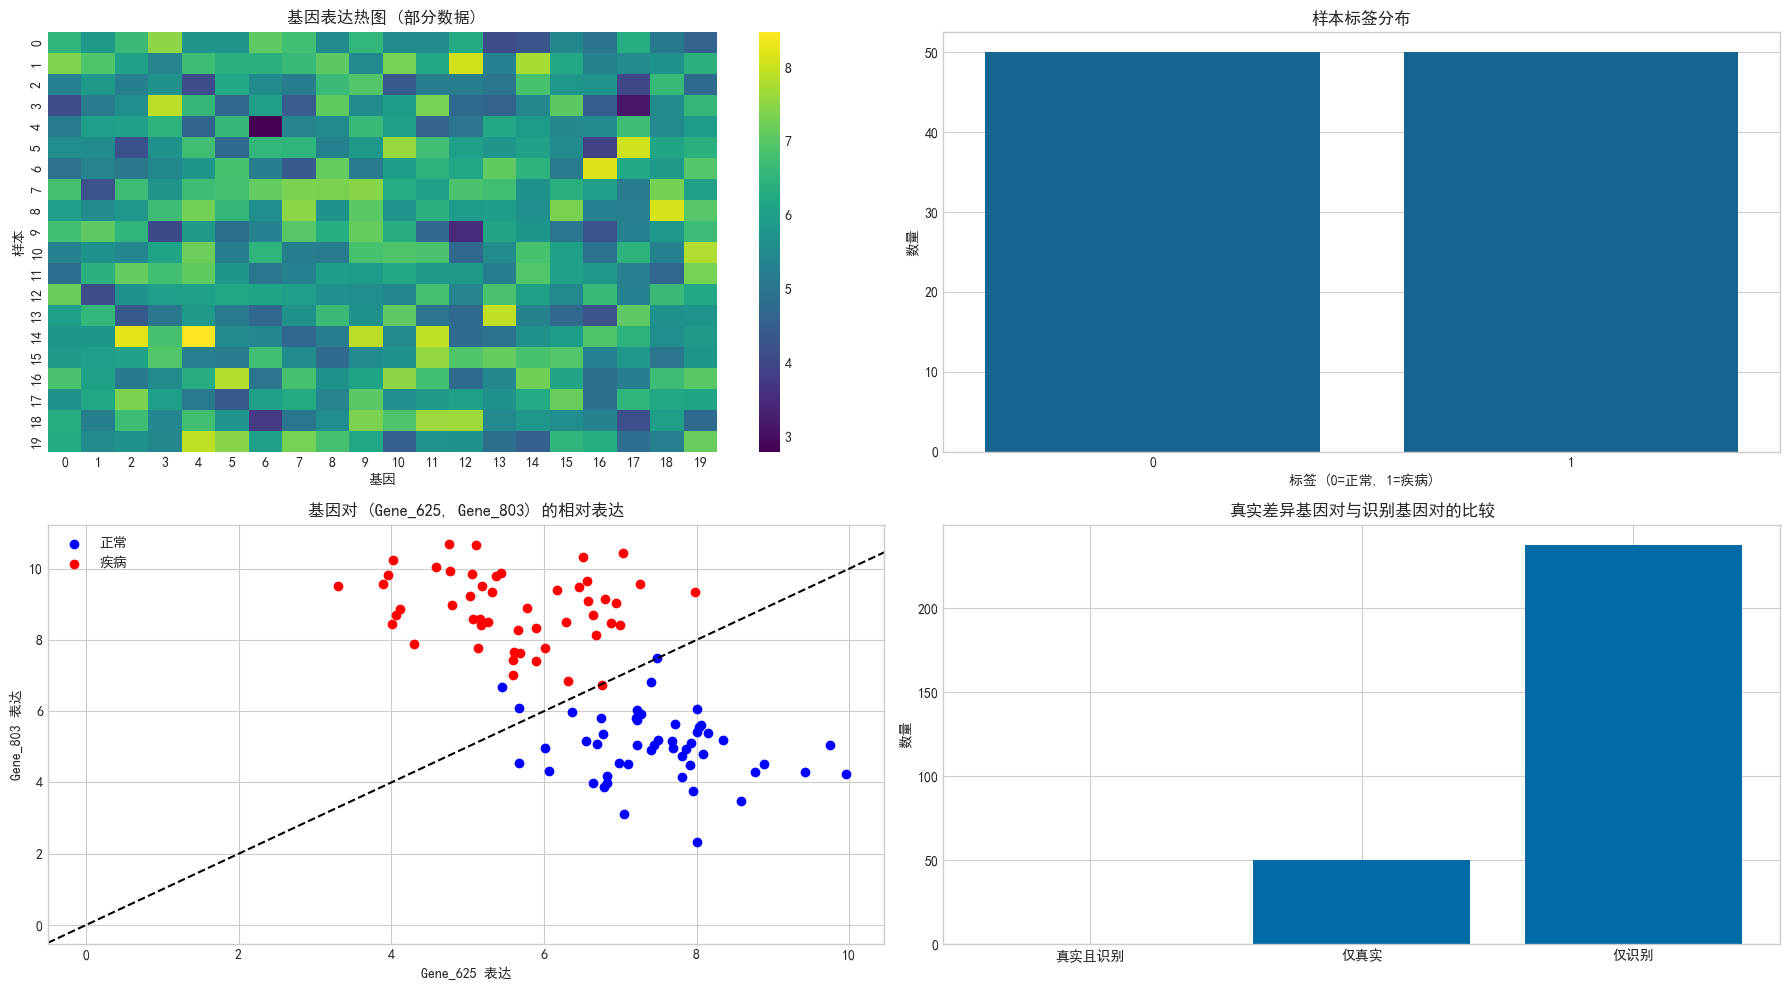

iPAGE算法模拟实验完成！


In [59]:
if __name__ == "__main__":
    run_ipage_with_real_pathways()